In [2]:
import numpy as np
import scipy.io as sio
import os
import random
import datetime
import csv
from typing import Dict
from scipy.fft import fft
from scipy.stats import kurtosis, skew
from vmdpy import VMD
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle
import json

In [ ]:
from data.cwru_loader import _default_file_mapping, CATEGORY_MAPPING, CATEGORY_ORDER

# 自动适配当前 Notebook 的工作目录，优先使用项目根目录下的 data/CRWU
_candidate_dirs = [
    os.path.join(".", "data", "CRWU"),
    os.path.join("..", "data", "CRWU"),
    os.path.join("..", "..", "data", "CRWU"),
]
DATA_DIR = None
for _p in _candidate_dirs:
    if os.path.isdir(_p):
        DATA_DIR = _p
        break
if DATA_DIR is None:
    raise FileNotFoundError("未找到 data/CRWU 目录，请检查项目根目录或修改 DATA_DIR 路径。")

FEATURE_FILE = "cwru_features_labels_4class_optimized.npz"  # 缓存的特征文件
SIGNAL_FILE = "cwru_signals_4class.npy"  # 新增：保存原始信号序列的缓存文件
KG_SAVE_DIR = r"./knowledge_graphs"  # 知识图谱保存目录
os.makedirs(KG_SAVE_DIR, exist_ok=True)  # 确保保存目录存在


# 故障类型到文件的映射：复用项目中针对 data/CRWU 结构的默认映射
file_mapping = _default_file_mapping()

# 类别映射与顺序：与项目中保持一致
category_mapping = CATEGORY_MAPPING
unique_categories = CATEGORY_ORDER

# 特征名称定义（对应31个特征，含具体含义，便于后续分析）
TIME_FEATURE_NAMES = [
    "Mean", "Std", "Sq-Mean-of-Sqrt", "RMS", "Peak",
    "Skewness", "Kurtosis", "Waveform-Factor", "Peak-Factor",
    "Impulse-Factor", "Crest-Factor"
]
FREQ_FEATURE_NAMES = [
    "Freq-Mean", "Freq-Var", "Freq-Skewness", "Freq-Kurtosis",
    "Freq-Center", "Freq-RMS", "Freq-Std", "Freq-4th-RMS",
    "Freq-Shape-Factor", "Freq-Skew-Factor", "Freq-Skewness-2", "Freq-Kurtosis-2"
]
VMD_FEATURE_NAMES = [
    "VMD-Energy-1", "VMD-Energy-2", "VMD-Energy-3", "VMD-Energy-4",
    "VMD-SVD-1", "VMD-SVD-2", "VMD-SVD-3", "VMD-SVD-4"
]
# 合并所有特征名称（共31个）
FULL_FEATURE_NAMES = TIME_FEATURE_NAMES + FREQ_FEATURE_NAMES + VMD_FEATURE_NAMES

# ======== 1. 数据加载函数 =========
def load_cwru_data_fixed(
    file_mapping: Dict,
    data_dir: str,
    sample_length: int = 2400,
    num_samples_per_class: int = 50,
    use_record: bool = False,
):
    """
    从 CWRU 数据集中抽样，并支持读取/写入抽样记录，确保未来可复现。

    参数：
    ----------
    use_record : bool
        - True  : 从记录文件中读取抽样起点，完全复现抽样
        - False : 随机抽样，并自动写入记录文件

    备注：
    ----------
    record_path 写死在函数内部，为 "cwru_samples_record.json"
    """

    # 写死的记录文件路径
    record_path = "cwru_samples_record.json"

    # 若 use_record=True，则尝试读取记录
    record = {}
    if use_record:
        if not os.path.exists(record_path):
            print(f"[警告] use_record=True 但记录文件 {record_path} 不存在，将退化为随机抽样。")
        else:
            with open(record_path, "r", encoding="utf-8") as f:
                record = json.load(f)
            print(f"[信息] 已从 {record_path} 读取抽样记录。")

    # 如果不使用记录，则我们准备一个新的记录结构
    new_record = {} if not use_record else None

    X, y = [], []

    for label_name, file_name in file_mapping.items():
        base_type = label_name.split('_')[0]
        category = category_mapping[base_type]
        category_idx = unique_categories.index(category)

        file_path = os.path.join(data_dir, file_name)
        if not os.path.exists(file_path):
            print(f"[文件缺失] {file_path}")
            continue

        data = sio.loadmat(file_path)
        signal_key = [k for k in data.keys() if "_DE_time" in k]
        if not signal_key:
            print(f"[未找到 DE_time 信号] {file_path}")
            continue

        signal = data[signal_key[0]].flatten()
        if len(signal) < sample_length:
            print(f"[信号过短] {file_path}, 长度: {len(signal)}")
            continue

        # 用 label+filename 作为唯一 key
        record_key = f"{label_name}|||{file_name}"

        # 若 use_record=True，则取出记录的起点
        if use_record and record:
            recorded_starts = record.get(record_key, [])
        else:
            recorded_starts = []

        # 在非复现模式下记录本文件起点
        if not use_record:
            new_record[record_key] = []

        valid_max_start = len(signal) - sample_length

        for i in range(num_samples_per_class):
            if use_record and recorded_starts and i < len(recorded_starts):
                # 使用记录起点
                start = int(recorded_starts[i])
                # 安全检查
                if start < 0 or start > valid_max_start:
                    print(
                        f"[警告] 记录起点无效: {start}，"
                        f"有效范围 [0, {valid_max_start}]，改为随机抽样"
                    )
                    start = random.randint(0, valid_max_start)
            else:
                # 随机抽样
                start = random.randint(0, valid_max_start)
                # 非复现模式：记录起点
                if not use_record:
                    new_record[record_key].append(int(start))

            segment = signal[start:start + sample_length]
            X.append(segment)
            y.append(category_idx)

        print(
            f"[完成] {label_name} -> {category} 从 {file_name} 采样 {num_samples_per_class} 个片段"
            + ("（使用记录）" if use_record and recorded_starts else "")
        )

    X = np.array(X)
    y = np.array(y)

    # 如果 use_record=False → 自动保存记录
    if not use_record:
        try:
            with open(record_path, "w", encoding="utf-8") as f:
                json.dump(new_record, f, ensure_ascii=False, indent=2)
            print(f"[信息] 抽样记录已写入 {record_path}")
        except Exception as e:
            print(f"[错误] 写记录文件失败: {e}")

    return X, y, unique_categories




# ======== 2. 特征提取函数 (更新以匹配论文公式) =========
def extract_time_domain_features(signal):
    """提取时域特征（11个特征，严格按论文TABLE I公式计算）"""
    N = len(signal)
    mean_val = np.mean(signal)  # p1
    std_val = np.std(signal, ddof=1)  # p2

    # 计算中间量
    abs_signal = np.abs(signal)
    sqrt_abs = np.sqrt(abs_signal)
    mean_abs = np.mean(abs_signal)  # 用于多个特征计算
    mean_sqrt_abs = np.mean(sqrt_abs)  # 方根幅值

    # 严格按照论文公式计算
    p1 = mean_val
    p2 = std_val
    p3 = np.square(np.mean(sqrt_abs))  # 平方幅值的均值
    p4 = np.sqrt(np.mean(signal ** 2))  # RMS
    p5 = np.max(abs_signal)  # 峰值
    p6 = skew(signal)  # 偏度
    p7 = kurtosis(signal)  # 峰度
    p8 = p5 / p4  # 峰值因子
    p9 = p5 / np.square(mean_sqrt_abs)  # 裕度因子
    p10 = p4 / mean_abs  # 波形因子
    p11 = p5 / mean_abs  # 脉冲因子


    return [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11]


def extract_frequency_domain_features(signal, fs=12000):
    """提取频域特征（12个特征，严格按论文TABLE II公式计算）"""
    n = len(signal)
    # 计算幅度谱（与论文中的s(l)一致）
    fft_vals = fft(signal)
    amplitude_spectrum = np.abs(fft_vals[:n // 2]) / n  # 幅度谱
    freqs = np.fft.fftfreq(n, 1 / fs)[:n // 2]
    L = len(amplitude_spectrum)
    s = amplitude_spectrum  # 使用s表示频谱，与论文一致

    # 严格按照论文公式计算
    p12 = np.sum(s) / L  # 频谱均值
    p13 = np.sum((s - p12) ** 2) / (L - 1)  # 频谱方差（N-1归一化）
    p14 = np.sum((s - p12) ** 3) / (L * (np.sqrt(p13)) ** 3)  # 频谱偏度
    p15 = np.sum((s - p12) ** 4) / (L * p13 ** 2)  # 频谱峰度
    p16 = np.sum(freqs * s) / np.sum(s)  # 频率重心
    p17 = np.sqrt(np.sum(freqs ** 2 * s) / np.sum(s))  # 均方频率
    p18 = np.sqrt(np.sum((freqs - p16) ** 2 * s) / L)  # 频率标准差
    p19 = np.sqrt(np.sum(freqs ** 4 * s) / np.sum(freqs ** 2 * s))  # 频率均方根
    numerator = np.sum(freqs ** 2 * s)
    denominator = np.sum(s) * np.sum(freqs ** 4 * s)
    p20 = np.sqrt(numerator / denominator)  # 频率形状因子
    p21 = p18 / p16  # 频率偏度因子
    p22 = np.sum((freqs - p16) ** 3 * s) / (L * p18 ** 3)  # 频率偏度因子2
    p23 = np.sum((freqs - p16) ** 4 * s) / (L * p18 ** 4)  # 频率峰度2

    return [p12, p13, p14, p15, p16, p17, p18, p19, p20, p21, p22, p23]


def extract_vmd_features(signal, alpha=1000, tau=0, K=4, DC=0, init=1, tol=1e-7):
    """提取VMD时频域特征（4个能量特征 + 4个奇异值特征）"""
    # VMD分解（需要确保有VMD实现）
    u, _, _ = VMD(signal, alpha, tau, K, DC, init, tol)

    # 确保分解得到4个模态
    if u.shape[0] != 4:
        raise ValueError(f"VMD分解应得到4个模态，但实际得到{u.shape[0]}个")

    # 1. 能量特征（4个）- 严格按论文公式计算
    energy_features = [np.sum(np.square(mode)) for mode in u]

    # 2. 奇异值特征（4个）
    mode_matrix = np.array(u)  # 4×N的模态矩阵
    U, S, Vh = np.linalg.svd(mode_matrix, full_matrices=False)
    svd_features = S.tolist()

    # 如果奇异值少于4个，用0填充
    while len(svd_features) < 4:
        svd_features.append(0.0)

    return energy_features + svd_features

In [4]:
def signals_to_features(X_signals, fs=12000,fit_scaler=True):
    """
    将原始信号序列转换为标准化特征矩阵 (N, 31)
    参数：
        X_signals : list/ndarray
            原始时域信号序列，每个元素为一段振动信号
        fs : int
            采样频率，默认为 12000Hz
        scaler : sklearn 标准化器（可复用已有的）
        fit_scaler : bool
            是否在本批数据上拟合标准化器（首次为 True，后续使用同一scaler时设 False）
    返回：
        feats_scaled : ndarray (N, 31)
            标准化后的特征矩阵
        scaler : 拟合后的 MinMaxScaler 对象（便于在后续阶段保持一致的缩放尺度）
    """

    feats = []
    for sig in X_signals:
        tfeats = extract_time_domain_features(sig)
        ffeats = extract_frequency_domain_features(sig, fs=fs)
        vfeats = extract_vmd_features(sig)
        feats.append(tfeats + ffeats + vfeats)

    feats = np.asarray(feats, dtype=np.float64)
    assert feats.shape[1] == len(FULL_FEATURE_NAMES), \
        f"期望 {len(FULL_FEATURE_NAMES)} 维，得到 {feats.shape[1]}"

    # ===== 新增：特征标准化 =====
    scaler = MinMaxScaler()
    if fit_scaler:
        feats_scaled = scaler.fit_transform(feats)
    else:
        feats_scaled = scaler.transform(feats)

    print(f"[标准化完成] 特征范围：{feats_scaled.min():.3f} ~ {feats_scaled.max():.3f}")
    return feats_scaled


# ================= KG: Step 2 & Step 3（仅依图片/Doc5 Step 2.1） =================
# 依赖：numpy、networkx（pip install networkx）



# ---- Step 2: 计算特征-故障相关性权重 w_{ik} ----
def compute_feature_fault_weights(X, y, class_names, feature_names, membership_soft=None):
    """
    X: (N, D) 特征矩阵（你上一步生成的 31 维）
    y: (N,) 硬标签 [0..C-1]
    membership_soft: (N, C) 可选，软成员度（若不提供，按 one-hot）
    返回:
      v: (C, D) 类中心 v_{ik}
      sigma: (C, D) 类内离散度 sigma_{ik} = sum_j u_{ij}(x_{jk}-v_{ik})^2
      w: (C, D) 相关性权重  w_{ik} = (sigma_{ik})^{-1/2} / sum_{k'}(...)
    """
    N, D = X.shape
    C = len(class_names)

    # 成员度 U (N, C)
    if membership_soft is not None:
        U = membership_soft.astype(float)
        U = np.clip(U, 0.0, 1.0)
    else:
        U = np.zeros((N, C), dtype=float)
        U[np.arange(N), y] = 1.0

    # v_{ik}
    denom = U.sum(axis=0, keepdims=True).T  # (C,1)
    denom[denom == 0] = 1e-12
    v = (U.T @ X) / denom  # (C,D)

    # sigma_{ik}
    sigma = np.zeros((C, D), dtype=float)
    for i in range(C):
        diff = X - v[i]        # (N,D)
        sigma[i] = (U[:, i][:, None] * (diff ** 2)).sum(axis=0)
    sigma = np.maximum(sigma, 1e-12)

    # w_{ik} ∝ (sigma_{ik})^{-1/2}，并在 k 维上归一
    inv_sqrt = 1.0 / np.sqrt(sigma)
    w = inv_sqrt / inv_sqrt.sum(axis=1, keepdims=True)

    # 便于检查：每类权重之和应为 1
    assert np.allclose(w.sum(axis=1), 1.0, atol=1e-6)

    # 保存到磁盘（可视化/复用）
    os.makedirs(KG_SAVE_DIR, exist_ok=True)
    np.savez(os.path.join(KG_SAVE_DIR, "kg_step2_w_v_sigma.npz"),
             w=w, v=v, sigma=sigma,
             feature_names=np.array(feature_names),
             class_names=np.array(class_names))
    return v, sigma, w

# ---- Step 3: 故障演化图（转移概率） ----
def build_fault_transition_matrix(y, num_classes, group_ids=None, smoothing=1e-3):
    """
    P[i,j] = P(fault_i -> fault_j)
    - 若给出 group_ids（同一设备/序列的片段编号），按组内索引顺序统计转移；
    - 否则用“自环为主+拉普拉斯平滑”的先验。
    """
    C = num_classes
    P = np.zeros((C, C), dtype=float)

    if group_ids is not None:
        from collections import defaultdict
        groups = defaultdict(list)
        for idx, g in enumerate(group_ids):
            groups[g].append(idx)
        for g, idxs in groups.items():
            idxs = sorted(idxs)
            for a, b in zip(idxs[:-1], idxs[1:]):
                P[y[a], y[b]] += 1.0
        P = P + smoothing
        P = P / P.sum(axis=1, keepdims=True)
    else:
        # 无时间顺序信息：构造保守的平滑马尔可夫矩阵
        P[:] = smoothing
        np.fill_diagonal(P, 1.0)
        P = P / P.sum(axis=1, keepdims=True)

    np.save(os.path.join(KG_SAVE_DIR, "kg_step3_P_transition.npy"), P)
    return P

# ---- 组装“知识图谱”：feature→fault（权重边） + fault→fault（转移边） ----
def assemble_kg_graph(w, P, class_names, feature_names, graph_name="bearing_KG"):
    """
    返回一个 networkx.DiGraph：
      节点：
        F_<k>  : feature 节点
        C_<i>  : fault 节点
      边：
        (F_k -> C_i)  权重 = w_{ik}
        (C_i -> C_j)  概率 = P_{ij}
    """
    G = nx.DiGraph(name=graph_name)

    # 节点
    for k, fn in enumerate(feature_names):
        G.add_node(f"F_{k}", kind="feature", name=fn)
    for i, cn in enumerate(class_names):
        G.add_node(f"C_{i}", kind="fault", name=cn)

    # feature -> fault
    C, D = w.shape
    for i in range(C):
        for k in range(D):
            weight = float(w[i, k])
            # 可阈值截断使图更清爽，例如 1e-6
            if weight > 1e-8:
                G.add_edge(f"F_{k}", f"C_{i}", etype="feature_fault", weight=weight)

    # fault -> fault
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            prob = float(P[i, j])
            if prob > 1e-8:
                G.add_edge(f"C_{i}", f"C_{j}", etype="fault_transition", prob=prob)

    # 保存 GraphML 和 JSON（任选其一查看/绘图）
    nx.write_graphml(G, os.path.join(KG_SAVE_DIR, "bearing_KG.graphml"))
    data = nx.node_link_data(G)
    with open(os.path.join(KG_SAVE_DIR, "bearing_KG.json"), "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    return G

# ---- 一键跑 KG（只做 Step2 & Step3） ----
if __name__ == "__main__":
    # 你前面已得到：X_signals, y, class_names
    # 并已转成 31 维特征矩阵 X
    # X = signals_to_features(X_signals, fs=12000)
# ============ 8. 一键运行：示例流程 ============

    # 1) 读取或生成样本（你已经有缓存的话，直接加载）
    X_signals, y, class_names = load_cwru_data_fixed(file_mapping, DATA_DIR, sample_length=2400, num_samples_per_class=100)

    # 2) 特征
    X = signals_to_features(X_signals, fs=12000)
    v, sigma, w = compute_feature_fault_weights(
        X=X, y=y, class_names=unique_categories, feature_names=FULL_FEATURE_NAMES,
        membership_soft=None  # 若后续有软成员度，可替换
    )
    P = build_fault_transition_matrix(y, num_classes=len(unique_categories), group_ids=None, smoothing=1e-3)
    G = assemble_kg_graph(w, P, class_names=unique_categories, feature_names=FULL_FEATURE_NAMES)

    print("KG 构建完成：")
    print("  - w shape:", w.shape, "(classes x features)")
    print("  - P shape:", P.shape, "(classes x classes)")
    print("  - Graph nodes/edges:", G.number_of_nodes(), G.number_of_edges())

[文件缺失] .\data\CWRU\97.mat
[文件缺失] .\data\CWRU\130.mat
[文件缺失] .\data\CWRU\105.mat
[文件缺失] .\data\CWRU\118.mat
[信息] 抽样记录已写入 cwru_samples_record.json


IndexError: tuple index out of range

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_bipartite_feature_fault(
    w, class_names, feature_names, topk=None,
    cmap_name="magma", min_width=0.8, max_width=5.0,
    node_size_feature=160, node_size_fault=600,
    figsize=(16, 9), title="Feature→Fault KG (bipartite)",
    draw_transitions=False, P=None, trans_thr=0.0
):
    """
    二部图可视化：上方为故障节点，下方为特征节点
    - 特征节点名称会显示在节点下方
    - 边的颜色和粗细按 w[i,k] 线性映射
    """

    C, D = w.shape
    w_min, w_max = float(np.min(w)), float(np.max(w))
    norm = Normalize(vmin=w_min, vmax=w_max, clip=True)
    cmap = cm.get_cmap(cmap_name)
    sm = ScalarMappable(norm=norm, cmap=cmap)

    # ===== 1. 构造布局 =====
    pos = {}
    xs_feat = np.linspace(0.02, 0.98, D)
    for k, x in enumerate(xs_feat):
        pos[f"F_{k}"] = (x, 0.1)   # 下方特征节点
    xs_cls = np.linspace(0.1, 0.9, C)
    for i, x in enumerate(xs_cls):
        pos[f"C_{i}"] = (x, 0.9)   # 上方故障节点

    # ===== 2. 选取需要画的边 =====
    edges = []
    if topk is None:
        for i in range(C):
            for k in range(D):
                edges.append((f"F_{k}", f"C_{i}", float(w[i, k])))
    else:
        for i in range(C):
            idx = np.argsort(w[i])[::-1][:topk]
            for k in idx:
                edges.append((f"F_{k}", f"C_{i}", float(w[i, k])))

    # ===== 3. 绘图 =====
    fig, ax = plt.subplots(figsize=figsize)

    feature_nodes = [f"F_{k}" for k in range(D)]
    fault_nodes = [f"C_{i}" for i in range(C)]

    # 如果没有 G，就创建一个空图
    _G = nx.DiGraph()
    _G.add_nodes_from(feature_nodes + fault_nodes)

    # --- 节点 ---
    nx.draw_networkx_nodes(
        _G, pos, nodelist=feature_nodes, node_color="#bcdff5",
        node_size=node_size_feature, edgecolors="#5b8fb9", linewidths=0.6, alpha=0.95, ax=ax
    )
    nx.draw_networkx_nodes(
        _G, pos, nodelist=fault_nodes, node_color="#f7b3ab",
        node_size=node_size_fault, edgecolors="#b85e57", linewidths=1.2, alpha=0.95, ax=ax
    )

    # --- 故障标签（上方） ---
    fault_labels = {f"C_{i}": class_names[i] for i in range(C)}
    nx.draw_networkx_labels(_G, pos, labels=fault_labels, font_size=11, font_weight="bold", ax=ax)

    # --- 特征标签（下方，小字号，下移一点） ---
    feat_labels = {f"F_{k}": feature_names[k] for k in range(D)}
    feat_label_pos = {n: (x, y - 0.04) for n, (x, y) in pos.items() if n.startswith("F_")}
    nx.draw_networkx_labels(_G, feat_label_pos, labels=feat_labels, font_size=7, ax=ax)

    # --- 边 ---
    for u, v, wt in edges:
        if u not in pos or v not in pos:
            continue
        color = cmap(norm(wt))
        width = float(min_width + (max_width - min_width) * norm(wt))
        nx.draw_networkx_edges(
            _G, pos, edgelist=[(u, v)],
            width=width, edge_color=[color],
            alpha=0.85, arrows=False, ax=ax
        )

    # --- 可选：画故障-故障转移 ---
    if draw_transitions and (P is not None):
        for i in range(C):
            for j in range(C):
                if i != j and P[i, j] > trans_thr:
                    nx.draw_networkx_edges(
                        _G, pos, edgelist=[(f"C_{i}", f"C_{j}")],
                        width=2.0 * P[i, j], edge_color="red", alpha=0.6, arrows=True, ax=ax
                    )

    # --- Colorbar ---
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("Feature→Fault weight $w_{ik}$", rotation=90)

    ax.set_title(title, fontsize=12)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_bipartite_feature_fault(
    w=w,
    class_names=unique_categories,
    feature_names=FULL_FEATURE_NAMES,
    topk=None,
    cmap_name="magma",
    min_width=0.8,
    max_width=5.0,
    figsize=(15, 8),
    title="Feature→Fault KG (Top-K with colorbar)",
    draw_transitions=False  # 如需叠加故障转移，改为 True 并传 P=P, trans_thr=0.01
)

# part2 GAN

In [ ]:
# ===== 2.2 Physics-Constrained Generative Augmentation (改进版，可直接替换) =====
# 依赖：PyTorch >= 1.10
import os
import math
import numpy as np
from typing import Dict, Tuple, Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# =============== 0. 实用函数 & 归一化 ==================
def to_tensor(x, device):
    return torch.as_tensor(x, dtype=torch.float32, device=device)

def minmax_scale_np(x, eps=1e-8):
    # 按样本把时域信号缩放到 [-1,1]，匹配 G 的 Tanh 输出
    x = np.asarray(x, dtype=np.float32)
    if x.ndim == 2:
        xmax = np.max(np.abs(x), axis=1, keepdims=True) + eps
        x = x / xmax
    elif x.ndim == 3:  # (N,1,T)
        xmax = np.max(np.abs(x), axis=(1,2), keepdims=True) + eps
        x = x / xmax
    return x

# =============== 1. 条件提供器 ==================
class ConditionProvider:
    def __init__(self, class_names, w_real: np.ndarray, E_c: np.ndarray, P: Optional[np.ndarray]=None):
        """
        w_real: (C, D_feat) —— 特征-故障相关性权重（来自你的 31维特征）
        E_c   : (C, 4)     —— 每类 VMD(近似)模态能量比例均值
        P     : (C, C)     —— 故障转移矩阵（可选，仅喂给 D）
        """
        self.class_names = list(class_names)
        self.C = len(class_names)
        self.w = np.asarray(w_real, dtype=np.float32)
        self.E = np.asarray(E_c, dtype=np.float32)
        self.P = None if P is None else np.asarray(P, dtype=np.float32)

    def get_cond_vectors_G(self, y: np.ndarray):
        """G 的条件：concat[w[y], E_c[y]]"""
        y = np.asarray(y, dtype=np.int64)
        w_take = self.w[y]       # (N, D_feat)
        E_take = self.E[y]       # (N, 4)
        return np.concatenate([w_take, E_take], axis=1)  # (N, D_feat + 4)

    def get_cond_vectors_D(self, y: np.ndarray):
        """D 的条件：concat[w[y], E_c[y], (可选)P[y]]"""
        y = np.asarray(y, dtype=np.int64)
        w_take = self.w[y]
        E_take = self.E[y]
        if self.P is None:
            return np.concatenate([w_take, E_take], axis=1)
        else:
            P_take = self.P[y]
            return np.concatenate([w_take, E_take, P_take], axis=1)

# =============== 2. 可微特征提取器（φ(x)） ==================
class DifferentiableFeatures(nn.Module):
    """
    用 rFFT 幅谱的前 K 维近似你的 31 维特征（K=31等），保持可微性以回传到 G。
    若你的 31 维有特定定义（时/频/包络等），可以逐步替换为严格可微实现。
    输出维度严格对齐 D_feat（例如 31）。
    """
    def __init__(self, sample_len: int = 2400, d_feat: int = 31):
        super().__init__()
        self.sample_len = sample_len
        self.d_feat = d_feat

    def forward(self, x):  # x: (B, 1, T)
        X = torch.fft.rfft(x.squeeze(1), dim=-1)       # (B, T//2+1)
        mag = torch.abs(X)
        # 均值池化到 d_feat 维（兼容不同 T//2+1）
        B, F = mag.shape
        if F < self.d_feat:
            pad = self.d_feat - F
            mag = F.pad(mag, (0, pad))
            F = mag.shape[1]
        idx = torch.linspace(0, F-1, self.d_feat, device=mag.device)
        idx0 = idx.floor().long().clamp(0, F-2)
        alpha = (idx - idx0.float()).unsqueeze(0)      # 线性插值
        base = mag[:, idx0] * (1 - alpha) + mag[:, idx0+1] * alpha
        feats = base                                    # (B, d_feat)
        return feats

# =============== 2.1 可微的四频带能量比例（近似 VMD 能量） ==================
class FourBandEnergy(nn.Module):
    """
    用 STFT 幅度谱在 4 个频带上积分，得到能量比例 (B,4)。
    可选：learnable_bands=True 时，带界限以单调参数化方式可学习（更贴合数据）。
    """
    def __init__(self, T: int, fs: int = 12000, nfft: int = 512, win_len: int = 256, hop: int = 128,
                 bands=None, learnable_bands: bool=False):
        super().__init__()
        self.fs = fs
        self.nfft = nfft
        self.hop = hop
        self.win_len = win_len
        self.register_buffer("window", torch.hann_window(win_len))
        # 默认四频带（示例），按你的转速/特征频可调整
        if bands is None:
            bands = [(0, 600), (600, 1800), (1800, 3600), (3600, 6000)]
        self.learnable_bands = learnable_bands
        if learnable_bands:
            # 用递增的累积 softplus 参数化边界，确保 0 < b1 < b2 < b3 < fs/2
            init = torch.tensor([bands[0][1], bands[1][1], bands[2][1], bands[3][1]], dtype=torch.float32)
            self.b_raw = nn.Parameter(torch.log(torch.exp(init/ (fs/2 - 1e-3)) - 1.0))  # 逆 softplus，粗略初始化
        else:
            self.bands = bands

    def _get_edges(self, device):
        if not self.learnable_bands:
            edges = torch.tensor([b[1] for b in self.bands], dtype=torch.float32, device=device)
        else:
            # 单调递增：b = (fs/2) * sigmoid(softplus(b_raw) 累积归一化)
            sp = F.softplus(self.b_raw)                # 正数
            cum = torch.cumsum(sp, dim=0)
            edges = (self.fs/2) * (cum / (cum[-1] + 1e-8))
        e0 = torch.tensor([0.0], device=device)
        edges = torch.cat([e0, edges], dim=0)          # (5,) -> [0,b1,b2,b3,b4]
        return edges

    def forward(self, x):  # x: (B,1,T)
        B = x.size(0)
        X = torch.stft(
            x.squeeze(1),
            n_fft=self.nfft,
            hop_length=self.hop,
            win_length=self.win_len,
            window=self.window.to(x.device),
            return_complex=True,
            center=True,
            pad_mode="reflect",
        )  # (B, F, T')
        mag2 = (X.real**2 + X.imag**2)  # (B,F,T') 能量谱
        Fbins = mag2.size(1)
        freqs = torch.linspace(0, self.fs/2, Fbins, device=x.device)  # (F,)

        edges = self._get_edges(x.device)  # (5,)
        Es = []
        for k in range(4):
            f0, f1 = edges[k], edges[k+1]
            mask = (freqs >= f0) & (freqs < f1)            # (F,)
            if mask.sum() == 0:
                band_E = mag2.new_zeros((B,))             # 空频带则置零
            else:
                band_E = mag2[:, mask, :].sum(dim=(1, 2)) # (B,)
            Es.append(band_E)
        E = torch.stack(Es, dim=1)                         # (B,4)
        E_ratio = E / (E.sum(dim=1, keepdim=True) + 1e-8)  # 归一成比例
        return E_ratio

# =============== 3. 生成器 G(z|c,w,E) ==================
class CondGenerator1D(nn.Module):
    def __init__(self, cond_dim: int, z_dim: int = 128, out_len: int = 2400, base_ch: int = 128, emb_dim: int = 16, num_classes: int = 4):
        super().__init__()
        self.out_len = out_len
        self.z_dim = z_dim
        self.emb = nn.Embedding(num_classes, emb_dim)  # Emb(c)
        self.cond_proj = nn.Linear(cond_dim + emb_dim, z_dim, bias=True)

        # 设计固定的上采样链，避免最后插值（更稳）
        self.init_len = 75
        self.fc = nn.Linear(z_dim * 2, base_ch * self.init_len)  # -> (B, C*L0)

        self.net = nn.Sequential(
            nn.ConvTranspose1d(base_ch, base_ch//2, 4, 2, 1),   # 75 -> 150
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(base_ch//2, base_ch//4, 4, 2, 1),# 150 -> 300
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(base_ch//4, base_ch//8, 4, 2, 1),# 300 -> 600
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(base_ch//8, base_ch//16, 4, 2, 1),#600 ->1200
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(base_ch//16, 1, 4, 2, 1),        #1200->2400
            nn.Tanh(),
        )

    def forward(self, z, cond_vec, y):
        emb = self.emb(y)                       # (B, emb_dim)
        cond_full = torch.cat([cond_vec, emb], dim=1)
        c = self.cond_proj(cond_full)           # (B, z_dim)
        h = torch.cat([z, c], dim=1)            # (B, 2*z_dim)
        h = self.fc(h)                          # (B, base_ch*init_len)
        B = h.size(0)
        C = h.numel() // (B * self.init_len)
        h = h.view(B, C, self.init_len)         # (B, base_ch, 75)
        x = self.net(h)                         # (B,1,2400)
        return x

# =============== 4. 判别器 D(x|cond)：Projection Discriminator ==================
class CondProjectionDiscriminator1D(nn.Module):
    def __init__(self, cond_dim: int, base_ch: int = 64):
        super().__init__()
        self.cond_proj = nn.Linear(cond_dim, base_ch*4)
        self.backbone = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv1d(1, base_ch, 9, 2, 4)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv1d(base_ch, base_ch*2, 9, 2, 4)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv1d(base_ch*2, base_ch*4, 9, 2, 4)),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.uncond_head = nn.utils.spectral_norm(nn.Conv1d(base_ch*4, 1, 7, padding=3))

    def forward(self, x, cond_vec, noise_std=0.02):
        if noise_std > 0:
            x = x + noise_std * torch.randn_like(x)
        h = self.backbone(x)                    # (B, C, T')
        g = h.mean(dim=-1)                      # (B, C)
        logits_uncond = self.uncond_head(h).mean(dim=-1).squeeze(1)  # (B,)
        e = self.cond_proj(cond_vec)            # (B, C)
        logits = logits_uncond + (g * e).sum(dim=1)
        return logits

# =============== 5. 物理约束损失 L_phy（含类内 EMA） ==================
class PhysicsConstraintLoss(nn.Module):
    """
    L_phy = ||w_gen - w_real||_2^2 + alpha_E * D_ratio(E_gen, E_c)
    其中：
      - w_gen：用 φ(x_gen) 的类内统计与 v_real 对齐后，按 EMA 聚合估计。
      - E_gen：可微四频带能量比例（近似 VMD）。
      - D_ratio：默认 L1，可选 'kl' 或 'logcosh'。
    """
    def __init__(self, v_real: np.ndarray, w_real: np.ndarray, E_c: np.ndarray,
                 feat_func: nn.Module, band_energy: nn.Module,
                 eps=1e-8, alpha_E=1.0, ratio_metric: str="l1", ema_momentum: float=0.1):
        super().__init__()
        v_real = np.asarray(v_real, dtype=np.float32)          # (C,D)
        w_real = np.asarray(w_real, dtype=np.float32)          # (C,D)
        E_c    = np.asarray(E_c, dtype=np.float32)             # (C,4)
        C, D = v_real.shape
        assert w_real.shape == (C, D), "w_real shape mismatch!"
        self.C, self.D = C, D
        self.register_buffer("v", torch.tensor(v_real))
        self.register_buffer("w_target", torch.tensor(w_real))
        self.register_buffer("E_target", torch.tensor(E_c))
        self.phi = feat_func
        self.band_energy = band_energy
        self.eps = eps
        self.alpha_E = alpha_E
        self.ratio_metric = ratio_metric
        self.m = ema_momentum

        # 类内 EMA 的二阶中心矩（围绕 v_real 的平方差）缓存
        self.register_buffer("ema_var", torch.ones(C, D))
        self.register_buffer("ema_ready", torch.zeros(C))  # 标记是否初始化

    def _ratio_distance(self, p, q):
        if self.ratio_metric == "l1":
            return F.l1_loss(p, q)
        elif self.ratio_metric == "kl":
            # 对比例向量更稳定的 KL（对称）
            p = (p + 1e-8); q = (q + 1e-8)
            return 0.5*( (p * (p/q).log()).sum(dim=1).mean() + (q * (q/p).log()).sum(dim=1).mean() )
        elif self.ratio_metric == "logcosh":
            return torch.log(torch.cosh(p - q)).mean()
        else:
            return F.l1_loss(p, q)

    def forward(self, x_gen: torch.Tensor, y: torch.Tensor):
        # ---- 权重项：用 φ(x_gen) 的类内方差（围绕 v_real） → w_gen，并做 EMA 聚合 ----
        feats = self.phi(x_gen)                        # (B, D_phi) -> 自动对齐 D
        if feats.shape[1] != self.D:
            # 线性投影/切片到 D 维
            feats = feats[:, :self.D] if feats.shape[1] > self.D else F.pad(feats, (0, self.D - feats.shape[1]))
        loss_w = 0.0
        classes = y.unique()
        for i in classes:
            i = int(i.item())
            mask = (y == i)
            Fi = feats[mask]                           # (B_i, D)
            if Fi.numel() == 0:
                continue
            vi = self.v[i]                             # (D,)
            # 当前 batch 的二阶中心矩
            cur_var = ((Fi - vi.unsqueeze(0))**2).mean(dim=0)  # (D,)
            # EMA 更新
            if self.ema_ready[i] < 0.5:
                self.ema_var[i] = cur_var.detach()
                self.ema_ready[i] = 1.0
            else:
                self.ema_var[i] = (1 - self.m) * self.ema_var[i] + self.m * cur_var.detach()
            invsqrt = torch.rsqrt(self.ema_var[i] + self.eps)
            wi_gen = invsqrt / (invsqrt.sum() + self.eps)
            wi_tgt = self.w_target[i]                  # (D,)
            loss_w = loss_w + F.mse_loss(wi_gen, wi_tgt)
        loss_w = loss_w / max(len(classes), 1)

        # ---- 能量比例项：可微四频带能量 vs. 目标 E_c ----
        Ec_gen = self.band_energy(x_gen)               # (B,4)
        Ec_tgt = self.E_target[y]                      # (B,4)
        loss_E = self._ratio_distance(Ec_gen, Ec_tgt)

        return loss_w + self.alpha_E * loss_E, loss_w.detach(), loss_E.detach()

# =============== 6. 数据集包装 ==================
class SignalsByClass(Dataset):
    def __init__(self, X_signals: np.ndarray, y: np.ndarray, do_minmax=True):
        X = np.asarray(X_signals, dtype=np.float32)
        if do_minmax:
            X = minmax_scale_np(X)         # 对齐 G 的 Tanh 范围
        if X.ndim == 2:
            X = X[:, None, :]              # (N,1,T)
        self.X = X
        self.y = np.asarray(y, dtype=np.int64)

    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.tensor(self.y[idx], dtype=torch.long)

# =============== 7. 训练器（Hinge + ProjectionD + n_critic + λ warmup） ==================
class PCG_Trainer:
    def __init__(
        self,
        X_signals,
        y,
        class_names,
        v_real,                  # (C,D)
        w_real,                  # (C,D)
        E_c=None,                # (C,4) 可选，若 None 则从真实信号估计
        P=None,                  # (C,C) 可选，仅喂 D（如果提供）
        batch_size=64,
        z_dim=128,
        lr_g=2e-4,
        lr_d=1e-4,               # TTUR：D 稍低也可；Hinge 对 lr 不太敏感
        lambda_phys=2.0,         # 物理项权重（可 warmup）
        alpha_E=1.0,
        device=None,
        fs=12000,
        n_critic=3,              # D:G = 3:1
        ratio_metric="l1",
        ema_momentum=0.1,
        learnable_bands=False,
        lambda_warmup_steps: int = 1000,
    ):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.dataset = SignalsByClass(X_signals, y, do_minmax=True)
        self.loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        # 条件
        if E_c is None:
            E_c = estimate_Ec_from_real(X_signals, y, fs=fs)
        self.cond = ConditionProvider(class_names, w_real, E_c, P=P)
        dummy_G = self.cond.get_cond_vectors_G(np.array([0]))
        dummy_D = self.cond.get_cond_vectors_D(np.array([0]))
        cond_dim_G = dummy_G.shape[1]
        cond_dim_D = dummy_D.shape[1]

        # 模型
        T = self.dataset.X.shape[-1]
        self.G = CondGenerator1D(cond_dim=cond_dim_G, z_dim=z_dim, out_len=T, num_classes=len(class_names)).to(self.device)
        self.D = CondProjectionDiscriminator1D(cond_dim=cond_dim_D).to(self.device)
        self.phi = DifferentiableFeatures(sample_len=T, d_feat=w_real.shape[1]).to(self.device)
        self.band_energy = FourBandEnergy(T=T, fs=fs, learnable_bands=learnable_bands).to(self.device)
        self.phys_loss = PhysicsConstraintLoss(
            v_real=v_real, w_real=w_real, E_c=E_c,
            feat_func=self.phi, band_energy=self.band_energy,
            alpha_E=alpha_E, ratio_metric=ratio_metric, ema_momentum=ema_momentum
        ).to(self.device)

        # 优化器（TTUR）
        self.optG = torch.optim.Adam(self.G.parameters(), lr=lr_g, betas=(0.5, 0.999))
        self.optD = torch.optim.Adam(self.D.parameters(), lr=lr_d, betas=(0.5, 0.999))
        self.lambda_phys_base = float(lambda_phys)
        self.lambda_phys = 0.0
        self.lambda_warmup_steps = int(lambda_warmup_steps)
        self.num_classes = len(class_names)
        self.n_critic = n_critic
        self.step = 0

    def _lambda_update(self):
        # 线性 warmup 到 lambda_phys_base
        if self.lambda_warmup_steps <= 0:
            self.lambda_phys = self.lambda_phys_base
        else:
            t = min(self.step / self.lambda_warmup_steps, 1.0)
            self.lambda_phys = (0.1 + 0.9 * t) * self.lambda_phys_base  # 前期更小，平滑升到目标

    def sample_noise(self, B, z_dim):
        return torch.randn(B, z_dim, device=self.device)

    def make_cond(self, y: torch.Tensor):
        condG_np = self.cond.get_cond_vectors_G(y.cpu().numpy())
        condD_np = self.cond.get_cond_vectors_D(y.cpu().numpy())
        return to_tensor(condG_np, self.device), to_tensor(condD_np, self.device)

    def d_hinge_loss(self, real_logits, fake_logits):
        return F.relu(1 - real_logits).mean() + F.relu(1 + fake_logits).mean()

    def g_hinge_loss(self, fake_logits):
        return - fake_logits.mean()

    def fit(self, epochs=50, log_every=50, d_noise_std=0.02):
        for ep in range(epochs):
            for xb, yb in self.loader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                B = xb.size(0)
                condG, condD = self.make_cond(yb)

                # ---- Train D (n_critic) ----
                for _ in range(self.n_critic):
                    self.optD.zero_grad()
                    real_logits = self.D(xb, condD, noise_std=d_noise_std)
                    z = self.sample_noise(B, self.G.z_dim)
                    x_fake = self.G(z, condG, yb).detach()
                    fake_logits = self.D(x_fake, condD, noise_std=d_noise_std)
                    d_loss = self.d_hinge_loss(real_logits, fake_logits)
                    d_loss.backward()
                    self.optD.step()

                # ---- Train G ----
                self.optG.zero_grad()
                z = self.sample_noise(B, self.G.z_dim)
                x_fake = self.G(z, condG, yb)
                fake_logits = self.D(x_fake, condD, noise_std=0.0)
                gan_loss = self.g_hinge_loss(fake_logits)
                phy, loss_w_det, loss_E_det = self.phys_loss(x_fake, yb)

                self._lambda_update()
                g_loss = gan_loss + self.lambda_phys * phy
                g_loss.backward()
                self.optG.step()

                if self.step % log_every == 0:
                    with torch.no_grad():
                        D_real = (real_logits > 0).float().mean().item()
                        D_fake = (fake_logits < 0).float().mean().item()
                        print(f"[ep {ep:03d} step {self.step:06d}] "
                              f"D: {d_loss.item():.4f} | G: {g_loss.item():.4f} | GAN: {gan_loss.item():.4f} "
                              f"| λ_phy:{self.lambda_phys:.3f} | L_phy:{phy.item():.4f} (w:{loss_w_det.mean().item():.4f}, E:{loss_E_det.mean().item():.4f}) "
                              f"| D_real>0:{D_real:.3f} | D_fake<0:{D_fake:.3f}")
                self.step += 1

    @torch.no_grad()
    def synthesize(self, y: np.ndarray, num_per_class=10):
        y = np.asarray(y, dtype=np.int64)
        all_out = []
        for yi in y:
            condG = self.cond.get_cond_vectors_G(np.array([yi]))
            condG = to_tensor(condG, self.device).repeat(num_per_class, 1)
            z = self.sample_noise(num_per_class, self.G.z_dim)
            xg = self.G(z, condG, torch.full((num_per_class,), yi, dtype=torch.long, device=self.device))
            all_out.append(xg.squeeze(1).cpu().numpy())
        Xg = np.concatenate(all_out, axis=0)   # (len(y)*num_per_class, T)
        return Xg

# =============== 8. 从真实信号估计 E_c（若未提供） ==================
def estimate_Ec_from_real(X_signals, y, fs=12000):
    from collections import defaultdict
    tmp_ds = SignalsByClass(X_signals, y, do_minmax=True)
    loader = DataLoader(tmp_ds, batch_size=128, shuffle=False, drop_last=False)
    band = FourBandEnergy(T=tmp_ds.X.shape[-1], fs=fs)
    by_cls = defaultdict(list)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    band = band.to(device)
    for xb, yb in loader:
        xb = xb.to(device)
        e = band(xb).cpu().numpy()  # (B,4)
        for ei, yi in zip(e, yb.numpy().tolist()):
            by_cls[yi].append(ei)
    C = len(np.unique(y))
    Ec = np.zeros((C,4), dtype=np.float32)
    for c in range(C):
        Ec[c] = np.mean(np.stack(by_cls[c], axis=0), axis=0)
    return Ec

# =============== 9. —— 使用示例 —— ==================

# 已有：
X_signals, y, unique_categories = load_cwru_data_fixed(file_mapping, DATA_DIR, sample_length=2400, num_samples_per_class=100)

X = signals_to_features(X_signals, fs=12000)
v, sigma, w = compute_feature_fault_weights(
    X=X, y=y, class_names=unique_categories, feature_names=FULL_FEATURE_NAMES,
    membership_soft=None  # 若后续有软成员度，可替换
)
# 然后根据你的定义得到:
#   v: (C, D) 每类的特征均值（用 feats_scaled 聚合）
#   w: (C, D) 相关性权重（按论文公式由类内方差归一得到）
#   P: (C, C) 可选，不给 G；若提供则只给 D（可置 None）

trainer = PCG_Trainer(
    X_signals=X_signals,
    y=y,
    class_names=unique_categories,
    v_real=v,                 # 形如 (C, 31)
    w_real=w,                 # 形如 (C, 31)
    E_c=None,                 # 若已有，可传入 (C,4)；否则会自动从 X_signals 估计
    P=None,                   # 可选：若你想让 D 也看到图结构，就传入 (C,C)
    lr_g=2e-4, lr_d=1e-4,     # TTUR
    lambda_phys=0.75, alpha_E=1.0,
    n_critic=3,
    ratio_metric="l1",        # 或 "kl"/"logcosh"
    learnable_bands=False,    # 若想让频带可学习，设 True（更贴合数据）
    lambda_warmup_steps=1000, # λ 线性 warm-up
)

trainer.fit(epochs=500, log_every=50)
Xg = trainer.synthesize(y=np.arange(len(unique_categories)), num_per_class=20)
print("Synthesized:", Xg.shape)



[完成] Normal_0 -> Normal 从 97.mat 采样 100 个片段
[完成] OR_007_0 -> Outer Race 从 130.mat 采样 100 个片段
[完成] IR_007_0 -> Inner Race 从 105.mat 采样 100 个片段
[完成] B_007_0 -> Ball 从 118.mat 采样 100 个片段
[信息] 抽样记录已写入 cwru_samples_record.json
[标准化完成] 特征范围：0.000 ~ 1.000
[ep 000 step 000000] D: 1.8963 | G: -0.0669 | GAN: -0.1009 | λ_phy:0.075 | L_phy:0.4535 (w:0.0072, E:0.4463) | D_real>0:1.000 | D_fake<0:0.000
[ep 008 step 000050] D: 0.5345 | G: 0.8905 | GAN: 0.8578 | λ_phy:0.109 | L_phy:0.3008 (w:0.0068, E:0.2940) | D_real>0:1.000 | D_fake<0:1.000
[ep 016 step 000100] D: 0.3428 | G: 0.7801 | GAN: 0.7613 | λ_phy:0.143 | L_phy:0.1321 (w:0.0066, E:0.1255) | D_real>0:1.000 | D_fake<0:1.000
[ep 025 step 000150] D: 0.0394 | G: 1.3606 | GAN: 1.3042 | λ_phy:0.176 | L_phy:0.3197 (w:0.0067, E:0.3130) | D_real>0:1.000 | D_fake<0:1.000
[ep 033 step 000200] D: 0.1670 | G: 1.8596 | GAN: 1.7855 | λ_phy:0.210 | L_phy:0.3530 (w:0.0064, E:0.3467) | D_real>0:1.000 | D_fake<0:1.000
[ep 041 step 000250] D: 0.1104 | G: 1.0872 |

(-1.0, 1.0)

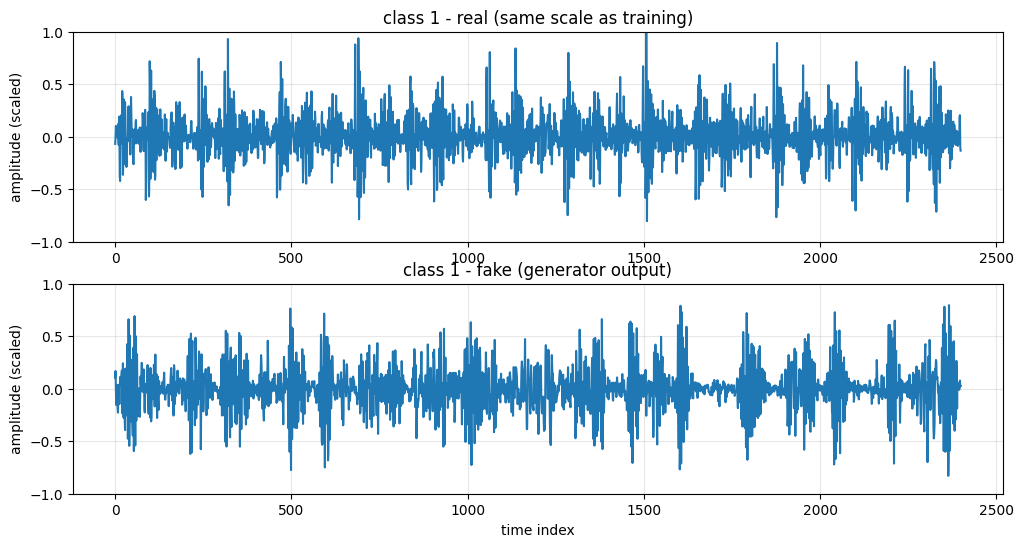

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# ===== 可视化：用“训练时的尺度”对比一类的 real / fake =====
cls = 1                      # 想看哪一类就改这里
num_per_class = 20        # 你 synthesize 里用的 num_per_class

# 1) 找一个该类的真实样本索引
idx_real = np.where(y == cls)[0][0]

# 2) 取训练时用的“已缩放”信号（注意：SignalsByClass 里已经做过 minmax_scale_np）
real_scaled = trainer.dataset.X[idx_real, 0]          # (T,)
# 3) 取生成的该类第一个样本（Xg 的排列是 [0类的20条，1类的20条，...]）
fake_scaled = Xg[cls * num_per_class + 0]             # (T,)


# 4) 各画一条在不同子图上，便于肉眼对比形状
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(real_scaled)
plt.title(f"class {cls} - real (same scale as training)")
plt.ylabel("amplitude (scaled)")
plt.grid(True, alpha=0.3)
plt.ylim(-1, 1)        # 统一 y 轴范围

plt.subplot(2, 1, 2)
plt.plot(fake_scaled)
plt.title(f"class {cls} - fake (generator output)")
plt.ylabel("amplitude (scaled)")
plt.xlabel("time index")
plt.grid(True, alpha=0.3)
plt.ylim(-1, 1)        # 统一 y 轴范围






Real subset: (80, 2400) Fake: (80, 2400)
[特征提取] 真实样本...
[特征提取] 生成样本...
time feats: (80, 11) (80, 11)
freq feats: (80, 12) (80, 12)
vmd  feats: (80, 8) (80, 8)
all  feats: (80, 31) (80, 31)
[t-SNE] TIME (11-D) 正在降维到 2 维用于可视化...
[t-SNE] TIME (11-D) 完成: (160, 2)
[t-SNE] FREQ (12-D) 正在降维到 2 维用于可视化...
[t-SNE] FREQ (12-D) 完成: (160, 2)
[t-SNE] VMD (8-D) 正在降维到 2 维用于可视化...
[t-SNE] VMD (8-D) 完成: (160, 2)
[t-SNE] ALL (31-D) 正在降维到 2 维用于可视化...
[t-SNE] ALL (31-D) 完成: (160, 2)


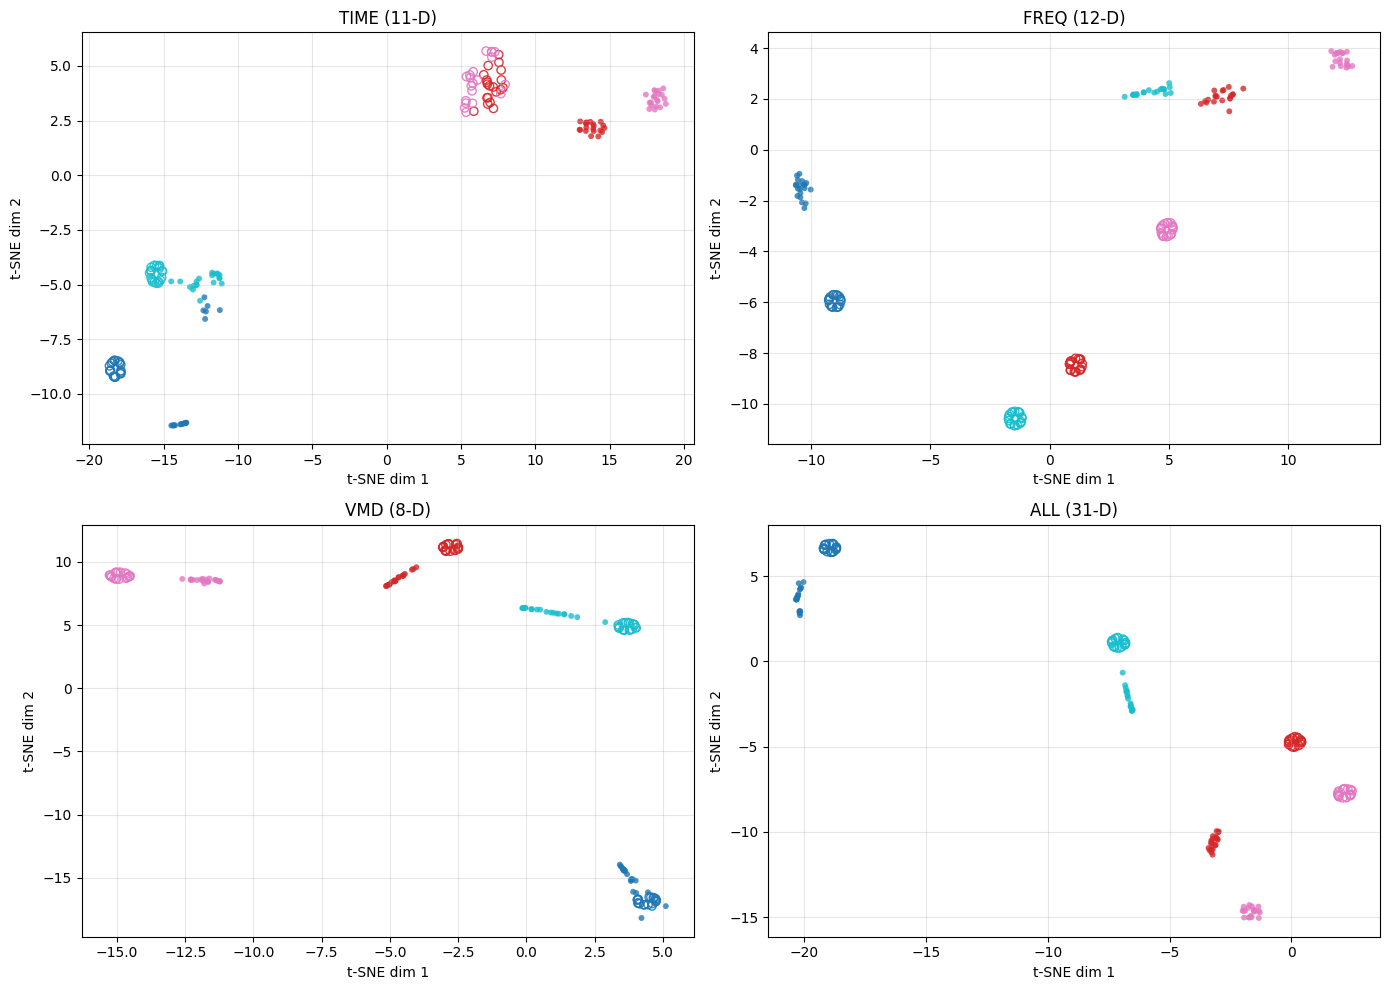

In [ ]:
# ===== 10. 提取特征 + t-SNE 可视化 GAN 结果（时域/频域/VMD 单独看，2×2 显示） =====
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ---------- 10.0 段内 min-max 归一化（real / fake 一视同仁） ----------
def segment_minmax(X, eps=1e-8):
    """
    对一批信号 X (N, T) 做逐段归一化：
        x_i <- x_i / max(|x_i|)
    """
    X = np.asarray(X, dtype=np.float32)
    max_abs = np.max(np.abs(X), axis=1, keepdims=True) + eps
    return X / max_abs

# ---------- 10.1 批量提取三类特征 ----------
def extract_features_batch(X, fs=12000):
    """
    对一批信号 X (N, T) 提取：
    - 11 维时域
    - 12 维频域
    - 8  维 VMD
    返回:
        feat_time: (N, 11)
        feat_freq: (N, 12)
        feat_vmd : (N, 8)
        feat_all : (N, 31)
    """
    feat_time, feat_freq, feat_vmd, feat_all = [], [], [], []
    for sig in X:
        sig = np.asarray(sig, dtype=np.float64)
        tfeats = extract_time_domain_features(sig)              # 11
        ffeats = extract_frequency_domain_features(sig, fs=fs)  # 12
        vfeats = extract_vmd_features(sig)                      # 8
        feat_time.append(tfeats)
        feat_freq.append(ffeats)
        feat_vmd.append(vfeats)
        feat_all.append(tfeats + ffeats + vfeats)

    feat_time = np.asarray(feat_time, dtype=np.float32)
    feat_freq = np.asarray(feat_freq, dtype=np.float32)
    feat_vmd  = np.asarray(feat_vmd,  dtype=np.float32)
    feat_all  = np.asarray(feat_all,  dtype=np.float32)

    assert feat_all.shape[1] == len(FULL_FEATURE_NAMES), \
        f"期望 {len(FULL_FEATURE_NAMES)} 维，得到 {feat_all.shape[1]}"

    return feat_time, feat_freq, feat_vmd, feat_all

# 为了 t-SNE 速度，你可以选一部分真实样本（比如每类采样跟生成一样多）
num_per_class = 20   # 你在 synthesize 里用的 num_per_class
C = len(unique_categories)

# ---------- 10.2 构造真实样本子集（与生成数量匹配） ----------
real_indices = []
for c in range(C):
    idx_c = np.where(y == c)[0]
    if len(idx_c) > num_per_class:
        idx_c = idx_c[:num_per_class]   # 每类只取前 num_per_class 个，防止太多
    real_indices.extend(idx_c.tolist())
real_indices = np.array(real_indices)

X_real_sub = X_signals[real_indices]            # (C * num_per_class, T)
y_real_sub = y[real_indices]                    # (C * num_per_class,)

# 生成样本已经是 (C * num_per_class, T)
X_fake = Xg                                     # (C * num_per_class, T)
y_fake = np.repeat(np.arange(C), num_per_class) # 对应的类别标签

print("Real subset:", X_real_sub.shape, "Fake:", X_fake.shape)

# ---------- 10.3 先统一做段内 minmax，再提特征 ----------
X_real_scaled = segment_minmax(X_real_sub)   # (N_real, T)
X_fake_scaled = segment_minmax(X_fake)       # (N_fake, T)

print("[特征提取] 真实样本...")
t_real, f_real, v_real, all_real = extract_features_batch(X_real_scaled, fs=12000)
print("[特征提取] 生成样本...")
t_fake, f_fake, v_fake, all_fake = extract_features_batch(X_fake_scaled, fs=12000)

# 打一个小表看一下维度
print("time feats:", t_real.shape, t_fake.shape)
print("freq feats:", f_real.shape, f_fake.shape)
print("vmd  feats:", v_real.shape, v_fake.shape)
print("all  feats:", all_real.shape, all_fake.shape)

# ---------- 10.4 支持绘制到子图中的 t-SNE 函数 ----------
def tsne_and_plot_ax(feat_real, feat_fake, y_real, y_fake, title, ax):
    """
    在 ax（子图）上绘制 t-SNE 结果
    feat_real, feat_fake: (N_real, D), (N_fake, D)
    y_real, y_fake       : 类别标签
    """
    X_feat_all = np.vstack([feat_real, feat_fake])
    domain_labels = np.concatenate([
        np.zeros(len(feat_real), dtype=int),  # 0 = real
        np.ones(len(feat_fake), dtype=int),   # 1 = fake
    ])
    class_labels = np.concatenate([y_real, y_fake])

    # 标准化
    scaler = StandardScaler()
    X_feat_all_std = scaler.fit_transform(X_feat_all)

    # t-SNE
    print(f"[t-SNE] {title} 正在降维到 2 维用于可视化...")
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate=200.0,   # 数值写法，兼容旧版 sklearn
        init="random",
        random_state=42,
    )
    X_emb = tsne.fit_transform(X_feat_all_std)
    print(f"[t-SNE] {title} 完成:", X_emb.shape)

    # 颜色
    colors = plt.cm.tab10(np.linspace(0, 1, C))

    for c in range(C):
        mask_real_c = (class_labels == c) & (domain_labels == 0)
        mask_fake_c = (class_labels == c) & (domain_labels == 1)

        # 实心点（真实）
        ax.scatter(
            X_emb[mask_real_c, 0],
            X_emb[mask_real_c, 1],
            s=18,
            c=colors[c].reshape(1, -1),
            alpha=0.8,
            marker="o",
            edgecolors="none",
        )
        # 空心点（生成）
        ax.scatter(
            X_emb[mask_fake_c, 0],
            X_emb[mask_fake_c, 1],
            s=36,
            facecolors="none",
            edgecolors=colors[c],
            alpha=0.9,
            marker="o",
            linewidths=1.0,
        )

    ax.set_title(title)
    ax.set_xlabel("t-SNE dim 1")
    ax.set_ylabel("t-SNE dim 2")
    ax.grid(True, alpha=0.3)

# ---------- 10.5 四种特征的 t-SNE 画成 2×2 ----------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) 只看 11 维时域特征
tsne_and_plot_ax(t_real, t_fake, y_real_sub, y_fake,
                 "TIME (11-D)", axes[0, 0])

# 2) 只看 12 维频域特征
tsne_and_plot_ax(f_real, f_fake, y_real_sub, y_fake,
                 "FREQ (12-D)", axes[0, 1])

# 3) 只看 8 维 VMD 特征
tsne_and_plot_ax(v_real, v_fake, y_real_sub, y_fake,
                 "VMD (8-D)", axes[1, 0])

# 4) 看完整 31 维特征（= 时域 + 频域 + VMD）
tsne_and_plot_ax(all_real, all_fake, y_real_sub, y_fake,
                 "ALL (31-D)", axes[1, 1])

plt.tight_layout()
plt.show()


